# Remaining Useful Life ($\textit{RUL}$) estimation of turbofan engines per flight class (FC)

This notebook contains code for estimating the Remaining Useful Life ($\textit{RUL}$) of turbofan engines experiencing a determined flight lengh (flight class). This case study makes use of the **new** C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) dataset from NASA for aircraft engines.More details about the generation process can be found at https://www.mdpi.com/2306-5729/6/1/5. 

This **new** C-MAPSS dataset comprises run-to-failure data of multiple engine units located at different $\textit{DS}$ sets. The degradation of each engine unit was simulated considering real operating conditions from a real jet in multiple flights. Flights are classified according their lenght: short-length flights (i.e., flight class 1), medium-length flights (i.e., flight class 2), or long-length flights (i.e., flight class 2).

| Flight Class   | Flight Length [h]
| :-----------:  | :-----------:    
| 1              |    1 to 3        
| 2              |    3 to 5        
| 3              |    5 to 7  

This notebook reused the inception-based CNN network from (https://doi.org/10.36001/phmconf.2021.v13i1.3109) and its pre-processing precedures to estimate the $\textit{RUL}$ of engines experiencing a determined flight class (FC).

This data partitioning is then used to simulate a collaborative prognostics problem in which three parties, each storing data from a determined FC, learn from each others without sharing raw data. 

To estimate the $\textit{RUL}$ of all available turbofan engines of a determined FC in $\textit{DS}$ sets, you must define the FC number in the hyperparameters section. You get a dataset for each class by previously executing:

- 1) Spliting a given dataset by Flight Class.ipynb
- 2) Concatenating datasets by Flight Class.ipynb

By running those notebooks, you can save and load FC*_dev.h5 and FC*_test.h5 sets. 



# Load Libraries

In [1]:
# packages
import os
import h5py
import time
import random
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
from time import gmtime, strftime
import random
import keras.backend as K
from tensorflow import keras
from keras import layers
from keras import models
from keras import regularizers
from keras.models import model_from_json
from sklearn.utils import shuffle
from pandas import DataFrame

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from itertools import product
from sklearn.decomposition import PCA
# import tensorflow_addons as tfa

# EVALUATION modules
from scipy.stats import spearmanr

params = {'legend.fontsize': 8,
          'figure.figsize': (9,6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':'xx-large',
         'axes.linewidth' : 2,
         'ytick.labelsize':'xx-large'}

plt.rcParams.update(params)


2024-03-01 10:43:48.635192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 10:43:48.635230: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 10:43:48.635249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 10:43:48.640664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices(device_type = 'GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
gpu=True
if gpu == True:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only use the first GPU
      try:
        tf.config.set_visible_devices(gpus[3], 'GPU')
      except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
        print(e)   

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


2024-03-01 10:43:50.311486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 10:43:50.311749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 10:43:50.311987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Hyperparameters

In [3]:
# Flight Class FC
FC = 3
DOWNSAMPLING_STEP=[2,2,8]

# LAYERS = [64,32]
LR = 0.01
BATCH_SIZE = 128
EPOCHS = 200

WINDOW_LEN = 30
stride = 1

PIECE_WISE=True

seed=571

np.random.seed(seed)

## Metrics

In [4]:
# mape error
def mape(real,predicted):
    return np.mean(np.abs((real - predicted) / real)) * 100

def mae(real,predicted):
    return np.mean(np.abs(real - predicted))

def rmse(real,predicted):
    return np.sqrt(np.mean((real - predicted)**2))

## Preprocessing

In [5]:
def normalize_data(x, lb, ub, max_v=1.0, min_v=-1.0):

    # Set-up
    if (lb == []) & (ub == []):
        # OPTION 1:
        ub = x.max(0)
        lb = x.min(0)
    
        # OPTION 2:
        #ub = np.percentile(x, 99.9, axis=0, keepdims=True)
        #lb = np.percentile(x, 0.1, axis=0, keepdims=True)
    
    ub.shape = (1,-1)
    lb.shape = (1,-1)           
    max_min = max_v - min_v
    delta = ub-lb

    # Compute
    x_n = max_min * (x - lb) / delta + min_v
    if 0 in delta:
        idx = np.ravel(delta == 0)
        x_n[:,idx] = x[:,idx] - lb[:, idx]

    return x_n, lb, ub 


def split_dataset(dataset, split=4): 
    '''
    Split 'dataset' in tree pieces: w, x_s, theta
    '''
    w = dataset[:,:split]
    x_s = dataset[:,split:20]
    theta = dataset[:,-10:]
    tmp = theta[:,6]
    tmp.shape = (-1,1)
    
    return w, x_s, tmp

def extract_units_ds(id_en, ds, units):
    '''
    Creates a subset with only id_en units for ds
    '''
    
    # Set-up
    ds_sub = []
    units_unique = np.unique(units)

    # Process
    for i in units_unique:
        if i in id_en:
            idx = np.ravel(units==i)
            ds_sub.append(ds[idx,:])           
    
    return np.concatenate(ds_sub, axis=0)

def create_lag_data(w, x_s, theta, y, Units, Cycles, stride=1):
    # Set-up
    W, X, T, Y, U, C, _W, _X = [], [], [], [], [], [], [], []
    
    # Loop over units and then within the units
    units = np.unique(Units)
    for k in units:
        unit = np.ravel(Units == k)
        w_unit = w[unit,:]
        x_s_unit = x_s[unit,:]
        T_unit = theta[unit,:]
        Y_unit = y[unit,:]
        U_unit = Units[unit,:]
        C_unit = Cycles[unit,:]
        dim = w_unit.shape[0]
        for i in range(dim-1): 
            X.append(x_s_unit[i + stride, :])          # X  or X_
            W.append(w_unit[i + stride, :])            # W  or W_
            T.append(T_unit[i + stride, :])            # T  or T_
            Y.append(Y_unit[i + stride, :])            # T  or T_
            U.append(U_unit[i + stride, :])            # U  or U_
            C.append(C_unit[i + stride, :])            # C  or C_
            _X.append(x_s_unit[i, :])                  # _X or X
            _W.append(w_unit[i, :])                  # _X or X
            
    return np.array(W), np.array(X), np.array(T), np.array(Y), np.array(U), np.array(C), np.array(_X), np.array(_W)



# np.array(X_out), np.array(W_out), np.array(Y_out), np.array(T_out), np.array(U_out), np.array(C_out), np.array(HI_out)

def split_sequences(input_data, sequence_length, stride = 1, option = None):
    """
     
    """
    X = list()
    
    for i in range(0,len(input_data),stride):
        # find the end of this pattern
        end_ix = i + sequence_length
        
        # check if we are beyond the dataset
        if end_ix > len(input_data):
            break
        
        # gather input and output parts of the pattern
        if option=='last':
            seq_x = input_data[end_ix-1, :]
        elif option=='next':
            seq_x = input_data[end_ix, :]
        else:
            seq_x = input_data[i:end_ix, :]
        X.append(seq_x)
    
    return np.array(X)



# def sequence_generator(input_data, units, sequence_length=10, option=None):
#     """
#      # Generates dataset with windows of sequence_length      
#     """  
#     X = list()
#     unit_num=[]
#     for i, elem_u in enumerate(list(np.unique(units))):
#         mask = np.ravel(units==elem_u)
#         seq_x_u = split_sequences(input_data[mask],sequence_length, option)
#         X.append(seq_x_u)
#         unit_num.extend(np.ones(len(seq_x_u),dtype = int)*elem_u)
    
#     return np.vstack(X),unit_num


## Plots

In [6]:
def plot_sensor_signal(x_real,x_pred,var_names,num=1000,figsize=10):
    input_dim = len(var_names)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    fig  = plt.figure(figsize=(figsize, max(figsize, rows*2)))   
    for i in range(input_dim):
        ax = fig.add_subplot(gs[i])
        # ax.plot(np.arange(0,num),x_real[-num:,i],label="True",marker='.',markeredgewidth=0.25, markersize=8)
        # ax.plot(np.arange(0,num),x_pred[-num:,i],label="Pred",marker='.',markeredgewidth=0.25, markersize=8)
        ax.scatter(np.arange(0,num),x_real[-num:,i],label="True",marker='.')
        ax.scatter(np.arange(0,num),x_pred[-num:,i],label="Pred",marker='.')
        plt.title(var_names[i])
        ax.legend()
    plt.tight_layout()
    plt.show()

##  Sequence Generator

In [7]:
def sequence_generator(input_data, units, cycles, sequence_length=10,stride = 1, option=None):
    """
     # Generates dataset with windows of sequence_length      
    """  
    X = list()
    unit_num=[]
    c_num =[]
    for i, elem_u in enumerate(list(np.unique(units))):
        mask = np.ravel(units==elem_u)
        c_mask = cycles[mask]
        x_unit = input_data[mask]
        for j in np.unique(c_mask):
            mask = np.ravel(c_mask==j)
            seq_x_u = split_sequences(x_unit[mask],sequence_length, stride, option)
            X.append(seq_x_u)
            unit_num.extend(np.ones(len(seq_x_u),dtype = int)*elem_u)
            c_num.extend(np.ones(len(seq_x_u),dtype = int)*j)
    
    return np.vstack(X),np.array(unit_num).reshape(-1,1),np.array(c_num).reshape(-1,1)


def sequence_generator_per_unit(input_data, units, cycles, sequence_length=10, stride =1,option=None):
    """
     # Generates dataset with windows of sequence_length      
    """  
    X = list()
    unit_num=[]
    c_num =[]
    for i, elem_u in enumerate(list(np.unique(units))):
        mask = np.ravel(units==elem_u)
        x_unit = input_data[mask]
        seq_x_u = split_sequences(x_unit,sequence_length, stride, option)
        X.append(seq_x_u)
        unit_num.extend(np.ones(len(seq_x_u),dtype = int)*elem_u)
        c_num.append(split_sequences(cycles[mask],sequence_length, stride, option))
    
    return np.vstack(X),np.array(unit_num).reshape(-1,1),np.vstack(c_num)

## Sampling

In [8]:
def sample_data(xs,w,y,t,units,cycles,hi,freq,mean = False):
    
    X_out,W_out,Y_out,T_out,U_out,C_out,HI_out= [], [], [], [], [], [] , []
    
    # Number of Trajectories (Units)
    uniq_units=np.unique(units)
    
    for k in uniq_units:
        unit = np.ravel(units == k)
        u_unit=units[unit,:]
        w_unit = w[unit,:]
        x_s_unit = xs[unit,:]
        y_unit= y[unit,:]
        t_unit= t[unit,:]
        c_unit= cycles[unit,:]
        h_unit = hi[unit]
        
        if mean:
            for i in range(0,x_s_unit.shape[0],freq):
                X_out.append(np.mean(x_s_unit[i:i+freq,:],axis=0))
                W_out.append(np.mean(w_unit[i:i+freq,:],axis=0))
                Y_out.append(np.mean(y_unit[i:i+freq,:],axis=0))
                T_out.append(np.mean(t_unit[i:i+freq,:],axis=0))
                HI_out.append(np.mean(h_unit[i:i+freq,:],axis=0))
            
            C_out.extend(c_unit[::freq])
            U_out.extend(u_unit[::freq])
        else:
        
            X_out.extend(x_s_unit[::freq,])
            W_out.extend(w_unit[::freq,])
            Y_out.extend(y_unit[::freq])
            U_out.extend(u_unit[::freq])
            T_out.extend(t_unit[::freq])
            C_out.extend(c_unit[::freq])
            HI_out.extend(h_unit[::freq])
            
    return  np.array(X_out).astype(np.float16),\
            np.array(W_out).astype(np.float16),\
            np.array(Y_out).astype(np.float16),\
            np.array(T_out).astype(np.float16),\
            np.array(U_out).astype(np.float16),\
            np.array(C_out).astype(np.float16),\
            np.array(HI_out).astype(np.float16)


In [9]:
def sample_healthy(data,units,cycles,cycle_len,sample_len=1):
    X,U,C=[],[],[]
    uniq_units=np.unique(units)
    for i in uniq_units:
        idx=np.ravel(units==i)
        cy=cycles[idx]
        x=data[idx,:]
        u=units[idx]
        cyidx=np.ravel(cy<=cycle_len)
        x=x[cyidx,:]
        u=u[cyidx]
        cyy = cy[cyidx]
        X.extend(x[::sample_len,:])
        U.extend(u[::sample_len])
        C.extend(cyy[::sample_len])
        
    return np.array(X), np.array(U), np.array(C)

def sample_healthy_mixed(data,units,cycles,starts,cycle_len,full=False):
    X,U,C=[],[],[]
    uniq_units=np.unique(units)
    for i in range(len(uniq_units)):
        idx=np.ravel(units==uniq_units[i])
        cy=cycles[idx]
        x=data[idx,:]
        u=units[idx]
        if full:
            cyidx=np.ravel((cy>=starts[i]))
        else:
            cyidx=np.ravel((cy>=starts[i])&(cy<=cycle_len+starts[i]))
        x=x[cyidx,:]
        u=u[cyidx]
        cyy = cy[cyidx]
        X.extend(x)
        U.extend(u)
        C.extend(cyy)
        
    return np.array(X), np.array(U), np.array(C)

## Smooth

In [10]:
def smooth_z_cycle(HI,T,units):
    results = []
    stds = []
    cycle_num =[]
    unit_num =[]
    for j in np.unique(units):
        idx = np.ravel(units==j)
        HI_unit = HI[idx]
        T_unit = T[idx].astype('float64')
        for jj in np.unique(T_unit):
            idxT = np.ravel(T_unit==jj)
            HI_mu_cycle = np.mean(HI_unit[idxT])
            std_cycle = np.std(HI_unit[idxT])
            results.append(HI_mu_cycle)
            stds.append(std_cycle)
            cycle_num.append(jj)
            unit_num.append(j)
    return np.array(results), np.array(stds),np.array(cycle_num),np.array(unit_num)

# Models

## RUL MODEL

In [11]:
#RUL MODEL

def predictor(t=64,
      feature_X_in=14,
      feature_W_in=4,
      feature_H_in=1,
      feature_out_size=1,
      activation='relu',
      filter = [10,10,1],
      filter_size = 10,
      useH=True):
    
    '''
    useH: if True, use H as input
        [X,W,H] -> Y 
    else:
        [X,W] -> Y
    '''

    x_in=layers.Input(shape=(t,feature_X_in),name="X_in")
    w_in = layers.Input(shape=(t,feature_W_in),name="W_in")
    
    
    if useH:
      h_in = layers.Input(shape=(t,feature_H_in),name="H_in")
      # h_in = layers.Input(shape=(1,1),name="H_in")
      x = tf.concat([x_in,w_in, h_in],-1)
    else: 
      x = tf.concat([x_in,w_in],-1)
      
    for i in filter:
      x = layers.Conv1D(i,filter_size,1,padding='same',activation = activation)(x)
      # x = layers.BatchNormalization()(x)
      
    x = layers.Flatten()(x)
    y = layers.Dense(50,activation = activation)(x)
    y = layers.Dense(feature_out_size,activation = 'linear')(y)

    if useH:
      model = models.Model([x_in,w_in,h_in], y)
    else:
      model = models.Model([x_in,w_in], y)

    return model

## MODEL FCN

In [12]:
#AE MODEL FCN
def AE(original_dimX,original_dimW,latent_dims,z_size = 1):
    
    inpX = layers.Input(shape=(original_dimX,))
    inpW = layers.Input(shape=(original_dimW,))
    x = tf.concat([inpX,inpW],axis = -1)
        

    for i in latent_dims:
        x=tf.keras.layers.Dense(i,activation='relu')(x)
        
    z = tf.keras.layers.Dense(z_size,name="Z")(x)
     
    x = tf.keras.layers.Concatenate()([z, inpW])
            
    for i in reversed(list(latent_dims)):
        x=tf.keras.layers.Dense(i,activation='relu')(x) 
    x=tf.keras.layers.Dense(original_dimX,name='X')(x)   
       
    model = models.Model([inpX,inpW],x)
    return model

# Model Inception

In [13]:

def inception2D(t=64,
      feature_X_in=14,
      feature_W_in=4,
      feature_out_size=1):
    
    '''
    useH: if True, use H as input
        [X,W,H] -> Y 
    else:
        [X,W] -> Y
    '''

    x_in=layers.Input(shape=(t,feature_X_in,1),name="X_in")
    w_in = layers.Input(shape=(t,feature_W_in,1),name="W_in")
    

    x = tf.concat([x_in,w_in],-2)
      
    layer_1 = tf.keras.layers.Conv2D(10, (3,3), padding='same', activation='relu')(x)

    layer_2 = tf.keras.layers.Conv2D(10, (5,5), padding='same', activation='relu')(x)

    layer_3 = tf.keras.layers.MaxPooling2D(3, strides=(1,1), padding='same')(x)
    layer_3 = tf.keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(layer_3)

    mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)

    ### 2nd Module
    layer_4 = tf.keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(mid_1)
    layer_4 = tf.keras.layers.Conv2D(10, (3,3), padding='same', activation='relu')(layer_4)

    layer_5 = tf.keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(mid_1)
    layer_5 = tf.keras.layers.Conv2D(10, (5,5), padding='same', activation='relu')(layer_5)

    layer_6 = tf.keras.layers.MaxPooling2D(1, strides=(1,1), padding='same')(mid_1)
    layer_6 = tf.keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(layer_6)

    mid_2 = tf.keras.layers.concatenate([layer_4, layer_5, layer_6], axis = 2)

    flat_1 = tf.keras.layers.Flatten()(mid_2)

    drop = tf.keras.layers.Dropout(.5)(flat_1)

    dense_1 = tf.keras.layers.Dense(256, activation='sigmoid')(drop)
    y = tf.keras.layers.Dense(feature_out_size, activation='relu')(dense_1)

    model = models.Model([x_in,w_in], y)

    return model

def inception1D(t=64,
      feature_X_in=14,
      feature_W_in=4,
      feature_out_size=1):
    
    '''
    useH: if True, use H as input
        [X,W,H] -> Y 
    else:
        [X,W] -> Y
    '''

    x_in=layers.Input(shape=(t,feature_X_in),name="X_in")
    w_in = layers.Input(shape=(t,feature_W_in),name="W_in")
    

    x = tf.concat([x_in,w_in],-1)
      
    layer_1 = tf.keras.layers.Conv1D(10, 3, padding='same', activation='relu')(x)

    layer_2 = tf.keras.layers.Conv1D(10, 5, padding='same', activation='relu')(x)

    layer_3 = tf.keras.layers.MaxPooling1D(3, strides=1, padding='same')(x)
    layer_3 = tf.keras.layers.Conv1D(10, 1, padding='same', activation='relu')(layer_3)

    mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 2)

    ### 2nd Module
    layer_4 = tf.keras.layers.Conv1D(10, 1, padding='same', activation='relu')(mid_1)
    layer_4 = tf.keras.layers.Conv1D(10, 3, padding='same', activation='relu')(layer_4)

    layer_5 = tf.keras.layers.Conv1D(10, 1, padding='same', activation='relu')(mid_1)
    layer_5 = tf.keras.layers.Conv1D(10, 5, padding='same', activation='relu')(layer_5)

    layer_6 = tf.keras.layers.MaxPooling1D(1, strides=1, padding='same')(mid_1)
    layer_6 = tf.keras.layers.Conv1D(10, 1, padding='same', activation='relu')(layer_6)

    mid_2 = tf.keras.layers.concatenate([layer_4, layer_5, layer_6], axis = 2)

    flat_1 = tf.keras.layers.Flatten()(mid_2)

    drop = tf.keras.layers.Dropout(.5)(flat_1)

    dense_1 = tf.keras.layers.Dense(256, activation='sigmoid')(drop)
    y = tf.keras.layers.Dense(feature_out_size, activation='relu')(dense_1)

    model = models.Model([x_in,w_in], y)

    return model

# Model construction

## Load Data

In [14]:
def correctRUL(hi, RUL):
    if hi == 1:
      return -1
    else:
      return RUL
def correctMaxRUL(hi, RUL,MAX_RUL):
    if hi == 1:
      return MAX_RUL
    else:
      return RUL

In [15]:
# Load data DEV
with h5py.File("FC"+str(FC)+"/FC"+str(FC)+'_dev'+".h5", 'r') as hdf:
            # Development set
            W_train = np.array(hdf.get('W_dev'), dtype='float16')             # W
            X_s_train = np.array(hdf.get('X_s_dev'), dtype='float16')         # X_s
            X_v_train = np.array(hdf.get('X_v_dev'), dtype='float16')         # X_v
            T_train = np.array(hdf.get('T_dev'), dtype='float16')             # T
            Y_train = np.array(hdf.get('Y_dev'), dtype='float16')             # RUL  
            A_train = np.array(hdf.get('A_dev'), dtype='float16')
            
            W_train = W_train[::DOWNSAMPLING_STEP[FC-1],:]
            X_s_train = X_s_train[::DOWNSAMPLING_STEP[FC-1],:] 
            X_v_train = X_v_train[::DOWNSAMPLING_STEP[FC-1],:] 
            T_train = T_train[::DOWNSAMPLING_STEP[FC-1],:]
            Y_train = Y_train[::DOWNSAMPLING_STEP[FC-1],:]
            A_train = A_train[::DOWNSAMPLING_STEP[FC-1],:]
            
            # Varnams
            W_var = np.array(hdf.get('W_var'))
            X_s_var = np.array(hdf.get('X_s_var'))  
            X_v_var = np.array(hdf.get('X_v_var')) 
            T_var = np.array(hdf.get('T_var'))
            A_var = np.array(hdf.get('A_var'))
            
                # from np.array to list dtype U4/U5
            W_var = list(np.array(W_var, dtype='U20'))
            X_s_var = list(np.array(X_s_var, dtype='U20'))  
            X_v_var = list(np.array(X_v_var, dtype='U20')) 
            T_var = list(np.array(T_var, dtype='U20'))
            A_var = list(np.array(A_var, dtype='U20'))
            

units_train=A_train[:,0].reshape(-1,1)
cycles_train=A_train[:,1].reshape(-1,1)
fc_train = A_train[:,2].reshape(-1,1)
hi_train = A_train[:,-1]

print("XS_train",X_s_train.shape)
print(units_train.shape)

XS_train (356815, 14)
(356815, 1)


## Correction of RUL based on health indicator 

In [16]:
if PIECE_WISE==True:
    df_hs_unit_train = DataFrame({'unit': units_train.reshape(-1).astype(int),'RUL': Y_train.reshape(-1), 'hi': hi_train.reshape(-1)})
    df_hs_unit_train['RUL']=df_hs_unit_train.apply(lambda row: correctRUL(row['hi'],row['RUL']), axis=1)

    pd_aux=DataFrame(df_hs_unit_train.groupby('unit')['RUL'].max()).reset_index()
    df_hs_unit_train['RUL']=df_hs_unit_train.apply(lambda row: correctMaxRUL(row['hi'],row['RUL'], float(pd_aux.iloc[pd_aux.index[pd_aux['unit'] == row['unit']]]['RUL'])), axis=1)
    Y_train=df_hs_unit_train['RUL'].to_numpy().reshape(len(df_hs_unit_train),1)

/tmp/ipykernel_3575392/1889809681.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_hs_unit_train['RUL']=df_hs_unit_train.apply(lambda row: correctMaxRUL(row['hi'],row['RUL'], float(pd_aux.iloc[pd_aux.index[pd_aux['unit'] == row['unit']]]['RUL'])), axis=1)


### MaxMin Scale $X_s$ and $W$

In [17]:
# SCALE

# scaler_X = MinMaxScaler(feature_range=(-1,1))
scaler_X = StandardScaler()
X_s_train = scaler_X.fit_transform(X_s_train)


# scaler_W = MinMaxScaler(feature_range=(-1,1))
scaler_W = StandardScaler()
W_train = scaler_W.fit_transform(W_train)

scaler_Y = MinMaxScaler(feature_range=(0,1))

Y_train = scaler_Y.fit_transform(Y_train)

### Downsamplig 0.1Hz

In [18]:

X_windows, U_windows, C_windows=sequence_generator(X_s_train,units_train,cycles_train,sequence_length=WINDOW_LEN,stride = stride)
W_windows,_,_=sequence_generator(W_train,units_train,cycles_train,sequence_length=WINDOW_LEN,stride = stride)
Y_windows,_,_=sequence_generator(Y_train,units_train,cycles_train,sequence_length=WINDOW_LEN,option='last',stride = stride)

## RUL MODEL

In [19]:
shuffle_idx = np.random.permutation(X_windows.shape[0])
training_idx, val_idx = shuffle_idx[X_windows.shape[0]//10:],shuffle_idx[:X_windows.shape[0]//10]

In [20]:
from datetime import datetime
past = datetime.now()
#x_temp = X_windows.reshape(X_windows.shape[0],X_windows.shape[1],X_windows.shape[2],1)
#w_temp = W_windows.reshape(W_windows.shape[0],W_windows.shape[1],W_windows.shape[2],1)
x_temp = X_windows
w_temp = W_windows

y_temp = Y_windows

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

t = X_windows.shape[1]
#rul_model = predictor(t=t,useH=False)
rul_model = inception1D(t=t)
OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=LR)
#LOSS = tf.keras.losses.MeanAbsoluteError()
#LOSS = tf.keras.losses.RootMeanSquaredError()
rul_model.compile(optimizer=OPTIMIZER, 
        loss= rmse, metrics=['mae',rmse])
        
callback = tf.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=5,restore_best_weights=True)  


train_ds = tf.data.Dataset.from_tensor_slices(((x_temp[training_idx],w_temp[training_idx]),y_temp[training_idx]))
train_ds = train_ds.shuffle(buffer_size=x_temp.shape[0]//10).batch(BATCH_SIZE)     
val_ds = tf.data.Dataset.from_tensor_slices(((x_temp[val_idx],w_temp[val_idx]),y_temp[val_idx]))    
val_ds = val_ds.shuffle(buffer_size=x_temp.shape[0]//10).batch(BATCH_SIZE) 
history = rul_model.fit(train_ds,epochs=EPOCHS,validation_data=val_ds,verbose=1,callbacks = [callback])

last = datetime.now()
time=last-past
print("Training Time =", time)

2024-03-01 10:45:06.933735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 10:45:06.934050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 10:45:06.934278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/200


2024-03-01 10:45:09.428854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-01 10:45:11.213845: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef80e2552e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 10:45:11.213865: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-01 10:45:11.287912: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2125/2125 [==============================] - 16s 6ms/step - loss: 0.2347 - mae: 0.1904 - rmse: 0.2347 - val_loss: 0.2414 - val_mae: 0.1996 - val_rmse: 0.2414
Epoch 2/200
2125/2125 [==============================] - 11s 5ms/step - loss: 0.2153 - mae: 0.1740 - rmse: 0.2153 - val_loss: 0.1843 - val_mae: 0.1433 - val_rmse: 0.1839
Epoch 3/200
2125/2125 [==============================] - 12s 5ms/step - loss: 0.1883 - mae: 0.1517 - rmse: 0.1883 - val_loss: 0.2047 - val_mae: 0.1645 - val_rmse: 0.2044
Epoch 4/200
2125/2125 [==============================] - 11s 5ms/step - loss: 0.1560 - mae: 0.1261 - rmse: 0.1560 - val_loss: 0.2039 - val_mae: 0.1673 - val_rmse: 0.2040
Epoch 5/200
2125/2125 [==============================] - 12s 5ms/step - loss: 0.1437 - mae: 0.1159 - rmse: 0.1437 - val_loss: 0.1368 - val_mae: 0.1073 - val_rmse: 0.1367
Epoch 6/200
2125/2125 [==============================] - 11s 5ms/step - loss: 0.1371 - mae: 0.1100 - rmse: 0.1371 - val_loss: 0.1300 - val_mae: 0.1061 - val_rmse:

In [21]:
#model.save_weights("model.h5")
rul_model.save_weights("RUL_MODEL/FC"+str(FC)+"/model.h5")
#model.save_weights("nodes8_main_model_t6.h5")
from keras.models import model_from_json
# serialize model to JSON
model_json = rul_model.to_json()
with open("RUL_MODEL/FC"+str(FC)+"/model.json", "w") as json_file:
    json_file.write(model_json)

In [22]:
#model.load_weights("model.h5")
 
json_file = open("RUL_MODEL/FC"+str(FC)+"/model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
rul_model = model_from_json(loaded_model_json)
rul_model.load_weights("RUL_MODEL/FC"+str(FC)+"/model.h5")

### Test

In [23]:
FC_TEST=FC
for FC in range(FC_TEST-1, FC_TEST):
        # Load data DEV
        with h5py.File("FC"+str(FC+1)+"/FC"+str(FC+1)+'_test'+".h5", 'r') as hdf:
            # Development set
            W_test = np.array(hdf.get('W_test'), dtype='float32')             # W
            X_s_test = np.array(hdf.get('X_s_test'), dtype='float32')         # X_s
            Y_test = np.array(hdf.get('Y_test'), dtype='float32')             # RUL                  
            A_test = np.array(hdf.get('A_test'), dtype='float32')
            
            W_test = W_test[::DOWNSAMPLING_STEP[FC],:]
            X_s_test = X_s_test[::DOWNSAMPLING_STEP[FC],:] 
            Y_test = Y_test[::DOWNSAMPLING_STEP[FC]]
            A_test = A_test[::DOWNSAMPLING_STEP[FC],:]

            # Varnams
            W_var = np.array(hdf.get('W_var'))
            X_s_var = np.array(hdf.get('X_s_var'))  
            X_v_var = np.array(hdf.get('X_v_var')) 
            T_var = np.array(hdf.get('T_var'))
            A_var = np.array(hdf.get('A_var'))

            # from np.array to list dtype U4/U5
            W_var = list(np.array(W_var, dtype='U20'))
            X_s_var = list(np.array(X_s_var, dtype='U20'))  
            X_v_var = list(np.array(X_v_var, dtype='U20')) 
            T_var = list(np.array(T_var, dtype='U20'))
            A_var = list(np.array(A_var, dtype='U20'))
        
        #if FC==0:
            W_test_aux = W_test
            X_s_test_aux = X_s_test
            Y_test_aux = Y_test
            A_test_aux = A_test
        #if FC!=0:
        #    W_test_aux = np.concatenate((W_test_aux, W_test), axis=0)  
        #    X_s_test_aux = np.concatenate((X_s_test_aux, X_s_test), axis=0)
        #    Y_test_aux = np.concatenate((Y_test_aux, Y_test), axis=0) 
        #    A_test_aux = np.concatenate((A_test_aux, A_test), axis=0)
            
units_test=A_test_aux[:,0].reshape(-1,1)
cycles_test=A_test_aux[:,1].reshape(-1,1)
hi_test = A_test_aux[:,-1]

if PIECE_WISE==True:
    df_hs_unit_test = DataFrame({'unit': units_test.reshape(-1).astype(int),'RUL': Y_test.reshape(-1), 'hi': hi_test.reshape(-1)})
    df_hs_unit_test['RUL']=df_hs_unit_test.apply(lambda row: correctRUL(row['hi'],row['RUL']), axis=1)

    pd_aux=DataFrame(df_hs_unit_test.groupby('unit')['RUL'].max()).reset_index()
    df_hs_unit_test['RUL']=df_hs_unit_test.apply(lambda row: correctMaxRUL(row['hi'],row['RUL'], float(pd_aux.iloc[pd_aux.index[pd_aux['unit'] == row['unit']]]['RUL'])), axis=1)
    Y_test_aux=df_hs_unit_test['RUL'].to_numpy().reshape(len(df_hs_unit_test),1)
      
X_s_test = scaler_X.fit_transform(X_s_test_aux)
W_test = scaler_W.fit_transform(W_test_aux)
Y_test = scaler_Y.fit_transform(Y_test_aux)
            
X_windows_test, U_windows_test,C_windows_test=sequence_generator_per_unit(X_s_test,units_test,cycles_test,sequence_length=WINDOW_LEN,stride = stride)
W_windows_test,_,_=sequence_generator_per_unit(W_test,units_test,cycles_test,sequence_length=WINDOW_LEN,stride = stride)
Y_windows_test,_,_=sequence_generator_per_unit(Y_test,units_test,cycles_test,sequence_length=WINDOW_LEN,option='last',stride = stride)

/tmp/ipykernel_3575392/1351474081.py:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_hs_unit_test['RUL']=df_hs_unit_test.apply(lambda row: correctMaxRUL(row['hi'],row['RUL'], float(pd_aux.iloc[pd_aux.index[pd_aux['unit'] == row['unit']]]['RUL'])), axis=1)


In [24]:
#X_windows_test = X_windows_test.reshape(X_windows_test.shape[0],X_windows_test.shape[1],X_windows_test.shape[2],1)
#W_windows_test = W_windows_test.reshape(W_windows_test.shape[0],W_windows_test.shape[1],W_windows_test.shape[2],1)

In [25]:
rul_predicted = rul_model.predict((X_windows_test,W_windows_test))

5169/5169 [==============================] - 8s 2ms/step


In [26]:
rul_predicted_ = scaler_Y.inverse_transform(rul_predicted)
groud_truth = scaler_Y.inverse_transform(Y_windows_test)

In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math 
mae=mean_absolute_error(rul_predicted_,groud_truth)
mse=mean_squared_error(rul_predicted_,groud_truth)
rmse=np.sqrt(mse)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 9.403834604830694
MSE: 151.15007995140124
RMSE: 12.294310877450645


In [28]:
def plot_predicted_true_rul(log_y_hat_test, unit_sel, Unit_test, C_test, rul_test):
    """
    Plots the predicted and true remaining useful life (RUL) for a given set of test data.
    
    Parameters:
    -----------
    log_y_hat_test : numpy.ndarray
        Logarithm of the predicted RUL for each cycle of each unit in the test data.
    unit_sel : list
        List of units to include in the plot.
    Unit_test : numpy.ndarray
        Array containing the unit numbers for each cycle in the test data.
    C_test : numpy.ndarray
        Array containing the cycle numbers for each cycle in the test data.
    rul_test : numpy.ndarray
        Array containing the true RUL for each cycle in the test data.
    
    Returns:
    --------
    None
    """
    for i in range(len(log_y_hat_test)):
        fig = plt.figure(figsize=(9, 7))
        leg = []
        
        # Plot predicted RUL
        for j in unit_sel:
            y_hat_mean, y_hat_max, y_hat_min = [], [], []
            unit = Unit_test == j
            c_test = np.sort(C_test[unit])-1
            idx = np.argsort(C_test[unit])
            y_hat_test = log_y_hat_test[i][unit]
            y_hat_test_sorted = y_hat_test[idx]
            for k in np.unique(c_test):
                y_hat_mean.append(np.mean(y_hat_test_sorted[c_test == k]))
                y_hat_max.append(np.max(y_hat_test_sorted[c_test == k]))
                y_hat_min.append(np.min(y_hat_test_sorted[c_test == k]))
            y_hat_mean = np.array(y_hat_mean, dtype=np.float64)
            y_hat_max = np.array(y_hat_max, dtype=np.float64)
            y_hat_min = np.array(y_hat_min, dtype=np.float64)
            plt.plot(np.unique(c_test), y_hat_mean, 'o', alpha=0.7, markersize=5)
            plt.fill_between(np.unique(c_test), y_hat_min, y_hat_max, alpha=0.3)
        # Plot true RUL
        plt.gca().set_prop_cycle(None)
        for j in unit_sel:        
            unit = Unit_test == j  
            c_test_unique = np.unique(np.sort(C_test[unit])-1)
            rul_test_unique = np.unique(rul_test[unit])
            rul_test_unique=np.append(rul_test_unique,np.zeros(len(c_test_unique)-len(rul_test_unique))+np.max(rul_test[unit]))
            plt.plot(c_test_unique, rul_test_unique[::-1], alpha=0.7)
            leg.append('Prediction-Traj.' + str(j))           
            leg.append('$RUL$-Traj.' + str(j))
        plt.legend(leg, loc='upper right')
        plt.ylabel(r'$Prediction$ & $RUL$ [cycles]')
        plt.xlabel('Time [cycles]')
        plt.ylim(top=90)
        plt.ylim(bottom=-5)

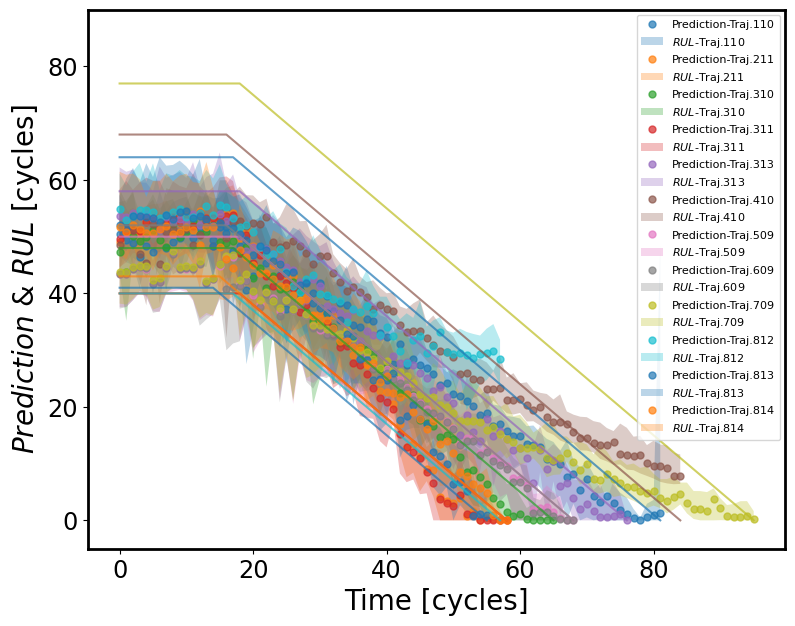

In [29]:
# FC1
if FC_TEST==1:
    units = [107,109,214,312,314,508,510,608,610,708,710,810,815] 
# FC2
if FC_TEST==2:
    units = [108,215,315,407,408,409,507,607,707,811,907,908,909,910] 
# FC3
if FC_TEST==3:
    units = [110,211,310,311,313,410,509,609,709,812,813,814]
 
numberUnits=4
start=0
numberUnits = int(len(units))
for x in range(start,len(units),numberUnits):
    if (x+2*numberUnits) < len(units):
    #if (x+numberUnits) < len(units):
        unit_sel = np.array(units[x:x+numberUnits], dtype=int)
        plot_predicted_true_rul([rul_predicted_], unit_sel, U_windows_test, C_windows_test[:,0,:], groud_truth)
    else:
        unit_sel = np.array(units[x:len(np.unique(U_windows_test))], dtype=int)
        plot_predicted_true_rul([rul_predicted_], unit_sel, U_windows_test, C_windows_test[:,0,:], groud_truth)

# Test All trajectories

In [30]:
for FC in range(0,3):
    # Load data TEST
    mode = '_test'
    with h5py.File("FC"+str(FC+1)+"/FC"+str(FC+1)+'_test'+".h5", 'r') as hdf:
                # Development set
                W_test = np.array(hdf.get('W_test'), dtype='float16')             # W
                X_s_test = np.array(hdf.get('X_s_test'), dtype='float16')         # X_s
                X_v_test = np.array(hdf.get('X_v_test'), dtype='float16')         # X_v
                T_test = np.array(hdf.get('T_test'), dtype='float16')             # T
                Y_test = np.array(hdf.get('Y_test'), dtype='float16')             # RUL  
                A_test = np.array(hdf.get('A_test'), dtype='float16')
                
                W_test = W_test[::DOWNSAMPLING_STEP[FC],:]
                X_s_test = X_s_test[::DOWNSAMPLING_STEP[FC],:]
                X_v_test = X_v_test[::DOWNSAMPLING_STEP[FC],:]
                T_test = T_test[::DOWNSAMPLING_STEP[FC],:] 
                Y_test = Y_test[::DOWNSAMPLING_STEP[FC],:]
                A_test = A_test[::DOWNSAMPLING_STEP[FC],:]
                
                if FC==1:
                    W_test_aux = W_test
                    X_s_test_aux = X_s_test
                    Y_test_aux = Y_test
                    A_test_aux = A_test
                if FC!=1:
                    W_test_aux = np.concatenate((W_test_aux, W_test), axis=0)  
                    X_s_test_aux = np.concatenate((X_s_test_aux, X_s_test), axis=0)
                    Y_test_aux = np.concatenate((Y_test_aux, Y_test), axis=0) 
                    A_test_aux = np.concatenate((A_test_aux, A_test), axis=0)
        

units_test=W_test_aux[:,0].reshape(-1,1)
cycles_test=A_test_aux[:,1].reshape(-1,1)
fc_test = A_test_aux[:,2].reshape(-1,1)
hi_test = A_test_aux[:,-1]

if PIECE_WISE==True:
    df_hs_unit_test = DataFrame({'unit': units_test.reshape(-1).astype(int),'RUL': Y_test_aux.reshape(-1), 'hi': hi_test.reshape(-1)})
    df_hs_unit_test['RUL']=df_hs_unit_test.apply(lambda row: correctRUL(row['hi'],row['RUL']), axis=1)

    pd_aux=DataFrame(df_hs_unit_test.groupby('unit')['RUL'].max()).reset_index()
    df_hs_unit_test['RUL']=df_hs_unit_test.apply(lambda row: correctMaxRUL(row['hi'],row['RUL'], float(pd_aux.iloc[pd_aux.index[pd_aux['unit'] == row['unit']]]['RUL'])), axis=1)
    Y_test_aux=df_hs_unit_test['RUL'].to_numpy().reshape(len(df_hs_unit_test),1)


# SCALE

X_s_test = scaler_X.transform(X_s_test_aux)
W_test = scaler_W.transform(W_test_aux)
Y_test = scaler_Y.transform(Y_test_aux)

X_windows_test, U_windows_test,C_windows_test=sequence_generator_per_unit(X_s_test,units_test,cycles_test,sequence_length=WINDOW_LEN,stride = stride)
W_windows_test,_,_=sequence_generator_per_unit(W_test,units_test,cycles_test,sequence_length=WINDOW_LEN,stride = stride)
Y_windows_test,_,_=sequence_generator_per_unit(Y_test,units_test,cycles_test,sequence_length=WINDOW_LEN,option='last',stride = stride)

rul_predicted = rul_model.predict((X_windows_test,W_windows_test))

rul_predicted_ = scaler_Y.inverse_transform(rul_predicted)
groud_truth = scaler_Y.inverse_transform(Y_windows_test)

mae=mean_absolute_error(rul_predicted_,groud_truth)
mse=mean_squared_error(rul_predicted_,groud_truth)
rmse=np.sqrt(mse)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

/tmp/ipykernel_3575392/110903034.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_hs_unit_test['RUL']=df_hs_unit_test.apply(lambda row: correctMaxRUL(row['hi'],row['RUL'], float(pd_aux.iloc[pd_aux.index[pd_aux['unit'] == row['unit']]]['RUL'])), axis=1)


20496/20496 [==============================] - 32s 2ms/step
MAE: 21.007693958845152
MSE: 694.7181302046115
RMSE: 26.357506145396446
